In [ ]:
import pandas as pd
import numpy as np

# Generate dates for 3 years
dates = pd.date_range(start="2021-01-01", end="2023-12-31", freq="D")

# Create sample values: trend + yearly + weekly pattern + noise
trend = np.linspace(50, 150, len(dates))                     # gradual upward trend
seasonal_yearly = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
seasonal_weekly = 5 * np.sin(2 * np.pi * dates.dayofweek / 7)
noise = np.random.normal(0, 3, len(dates))

values = trend + seasonal_yearly + seasonal_weekly + noise

# Create dataframe
df = pd.DataFrame({"date": dates, "value": values})

# Save to CSV
df.to_csv("time_series_dataset.csv", index=False)

print("✅ Dataset created: time_series_dataset.csv")
print(df.head())

✅ Dataset created: time_series_dataset.csv
        date      value
0 2021-01-01  49.131969
1 2021-01-02  47.207775
2 2021-01-03  47.240990
3 2021-01-04  53.037919
4 2021-01-05  60.632661


Loaded time_series_dataset.csv
MAE: 2.7048, RMSE: 3.3771


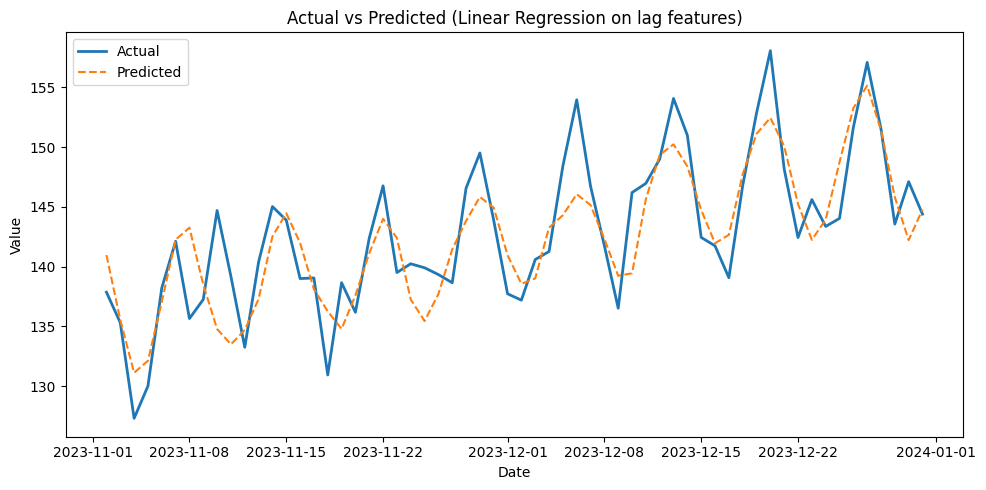

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/


Next 14-day Forecast:
              forecast
date                  
2024-01-01  149.191571
2024-01-02  153.843800
2024-01-03  155.476135
2024-01-04  152.592053
2024-01-05  146.589681
2024-01-06  143.522041
2024-01-07  144.725696
2024-01-08  149.981283
2024-01-09  154.470688
2024-01-10  155.714994
2024-01-11  153.469927
2024-01-12  148.206597
2024-01-13  144.441863
2024-01-14  145.434981

Saved forecast to time_series_forecast.csv


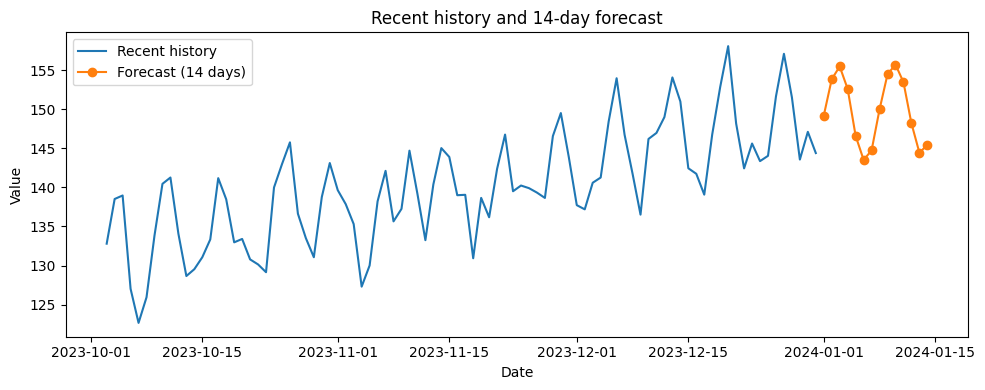

In [ ]:
# Corrected time-series training + forecasting script
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Load or create dataset ---
try:
    df = pd.read_csv("time_series_dataset.csv", parse_dates=["date"])
    df.set_index("date", inplace=True)
    print("Loaded time_series_dataset.csv")
except FileNotFoundError:
    print("time_series_dataset.csv not found — generating example dataset...")
    dates = pd.date_range(start="2021-01-01", end="2023-12-31", freq="D")
    trend = np.linspace(50, 150, len(dates))
    seasonal_yearly = 10 * np.sin(2 * np.pi * dates.dayofyear / 365)
    seasonal_weekly = 5 * np.sin(2 * np.pi * dates.dayofweek / 7)
    noise = np.random.normal(0, 3, len(dates))
    values = trend + seasonal_yearly + seasonal_weekly + noise
    df = pd.DataFrame({"date": dates, "value": values}).set_index("date")
    df.to_csv("time_series_dataset.csv")
    print("Created time_series_dataset.csv")

# --- Create lag features (past 30 days) ---
nlags = 30
for lag in range(1, nlags + 1):
    df[f"lag_{lag}"] = df["value"].shift(lag)
df.dropna(inplace=True)

# --- Train/Test split (last 60 days test) ---
train = df[:-60]
test = df[-60:]

X_train = train.drop(columns=["value"])
y_train = train["value"]
X_test = test.drop(columns=["value"])
y_test = test["value"]

# --- Train model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predict on test set ---
predictions = model.predict(X_test)

# --- Evaluation (fix for older sklearn) ---
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))   # compute RMSE manually
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# --- Plot actual vs predicted ---
plt.figure(figsize=(10,5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, predictions, label="Predicted", linestyle="--")
plt.title("Actual vs Predicted (Linear Regression on lag features)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# --- Forecast next N days using iterative prediction ---
horizon = 14
# Start with the last available values (most recent nlags values)
last_values = df["value"].values[-nlags:].tolist()  # list of last nlags values in chronological order

future_dates = []
future_preds = []
for i in range(horizon):
    # create feature vector: lag_1 ... lag_nlags where lag_1 is value 1 day ago etc.
    # our model expects features in order lag_1, lag_2, ..., lag_n
    x = np.array(last_values[-nlags:][::-1]).reshape(1, -1)  # reverse so lag_1 is most recent
    next_val = model.predict(x)[0]
    # append prediction
    future_preds.append(next_val)
    next_date = df.index[-1] + pd.Timedelta(days=i+1)
    future_dates.append(next_date)
    # update last_values with new prediction for iterative forecasting
    last_values.append(next_val)

# --- Show & save forecast ---
forecast_df = pd.DataFrame({"date": future_dates, "forecast": future_preds})
forecast_df.set_index("date", inplace=True)
print("\nNext 14-day Forecast:")
print(forecast_df)

forecast_df.to_csv("time_series_forecast.csv")
print("\nSaved forecast to time_series_forecast.csv")

# Optional: plot recent history + forecast
plt.figure(figsize=(10,4))
plt.plot(df.index[-90:], df["value"].values[-90:], label="Recent history")
plt.plot(forecast_df.index, forecast_df["forecast"].values, marker='o', label="Forecast (14 days)")
plt.title("Recent history and 14-day forecast")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()